## Dependencias

In [139]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression,VarianceThreshold

from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd

from glob import glob

from scipy import stats 
from varclushi import VarClusHi

from functools import reduce
import warnings

warnings.filterwarnings('ignore')
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:0.3f}')

## Lectura de datos

In [140]:
ruta = "/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/02.  Para Ingeniería/nyc_taxi/green_*.csv"

In [141]:
data = pd.concat(map(lambda a:pd.read_csv(a,dtype=str),glob(ruta)),ignore_index=True)
data.shape

(17786053, 20)

In [9]:
varf = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']
um = ['PULocationID','DOLocationID']
varc = ['passenger_count','trip_distance','total_amount']
cols = um+varf+varc
data = data[cols]
data.sample(3)

NameError: name 'data' is not defined

In [5]:
for v in varf:
    data[v] = pd.to_datetime(data[v],format='%Y-%m-%d %H:%M:%S',errors='coerce').dt.date

In [6]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

In [7]:
data.head()

,PULocationID,DOLocationID,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,total_amount
0,193,193,2019-03-01,2019-03-01,1.000,0.000,6.240
1,80,256,2019-03-01,2019-03-01,1.000,0.720,8.160
2,7,179,2019-03-01,2019-03-01,1.000,0.500,5.300
3,256,80,2019-02-28,2019-03-01,1.000,1.190,8.760
4,223,223,2019-03-01,2019-03-01,1.000,0.550,5.300


## Análisis exploratorio preliminar

### Fechas 

In [8]:
data['lpep_pickup_datetime'].agg(['min','max'])

min    2008-10-21
max    2081-06-24
Name: lpep_pickup_datetime, dtype: object

In [9]:
data['lpep_pickup_datetime'].map(lambda x:x.strftime('%Y%m')).value_counts().sort_index().iplot(kind='line',color='purple')

In [10]:
data = data[(data['lpep_pickup_datetime']>=date(2020,4,1))&(data['lpep_pickup_datetime']<date(2022,3,1))].reset_index(drop=True)
data.shape

(1864850, 7)

In [11]:
data.sample(3)

,PULocationID,DOLocationID,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,total_amount
939718,167,167,2021-02-20,2021-02-20,1.000,0.070,8.760
1513533,32,32,2021-04-02,2021-04-02,0.000,0.020,10.300
906799,169,69,2021-08-23,2021-08-23,NaN,1.240,21.570


### Extremos

In [12]:
for v,li,ls in data[varc].describe(percentiles=[0.01,0.05,0.95,0.99]).T[['1%','99%']].reset_index().values:
    data = data[(data[v]>=li)&(data[v]<=ls)].reset_index(drop=True)

array([[<Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'trip_distance'}>],
       [<Axes: title={'center': 'total_amount'}>, <Axes: >]], dtype=object)

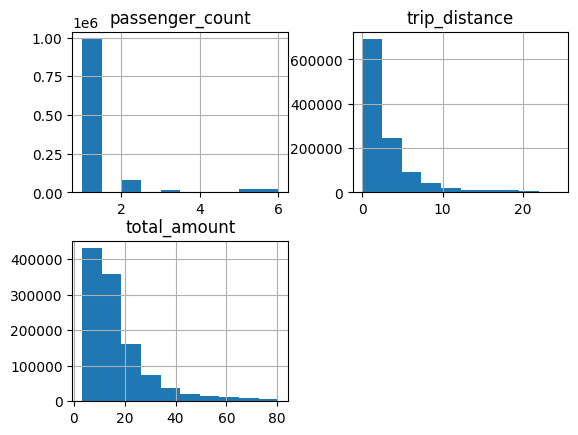

In [13]:
data[varc].hist()

### Agregar cuantificador de viaje

In [14]:
data['n'] = 1
varc.append('n')

## Ingeniería de variables (características)

### Definición de ventanas de observación y desempeño

In [15]:
vobs = 6
vdes = 1
fhi,fhf = pd.to_datetime(data['lpep_pickup_datetime'].map(lambda x:x.strftime('%Y-%m-01'))).dt.date.agg(['min','max'])
fhi,fhf = fhi+rd(months=vobs-1),fhf-rd(months=vdes)
fhi,fhf 

(datetime.date(2020, 9, 1), datetime.date(2022, 1, 1))

In [16]:
apilar = lambda x,y:pd.concat([x,y],ignore_index=True)

### Matriz de predictoras ($\mathcal{X}$)

In [38]:
def ingX(data,ancla):
    aux = data[(data['lpep_pickup_datetime']>=(ancla-rd(months=vobs-1)))&(data['lpep_pickup_datetime']<=ancla)].copy().reset_index(drop=True)
    funcs = [np.sum,np.mean,np.std,np.min,np.max,np.median]
    noms = ['sum','mean','std','min','max','median']
    expr = {f'x_{v}_{n}':(v,f) for v in varc for f,n in zip(funcs,noms)}
    aux = aux.groupby(um).agg(**expr).reset_index()
    aux.insert(2,'ancla',ancla)
    return aux

In [39]:
X = reduce(apilar,
map(lambda ancla:ingX(data,ancla),
map(lambda d:d.date(),pd.date_range(start=fhi, end=fhf, freq='MS'))))

In [40]:
X.shape

(227037, 27)

### Variable objetivo (vector respuesta $\vec{y}$)

In [71]:
def ingY(data,ancla):
    aux = data[(data['lpep_pickup_datetime']>=(ancla+rd(months=vdes)))&(data['lpep_pickup_datetime']<(ancla+rd(months=vdes+1)))].copy().reset_index(drop=True)
    expr = {'target':('n','sum')}
    aux = aux.groupby(um).agg(**expr).reset_index()
    aux.insert(2,'ancla',ancla)
    return aux

In [72]:
y = reduce(apilar,
map(lambda ancla:ingY(data,ancla),
map(lambda d:d.date(),pd.date_range(start=fhi, end=fhf, freq='MS'))))

### Tabla Análtica de Datos (TAD)

In [73]:
um.append('ancla')

In [74]:
tad = X.merge(y,on=um,how='inner')

In [75]:
tad.shape

(85933, 28)

In [76]:
tad.head()

,PULocationID,DOLocationID,ancla,x_passenger_count_sum,x_passenger_count_mean,x_passenger_count_std,x_passenger_count_min,x_passenger_count_max,x_passenger_count_median,x_trip_distance_sum,x_trip_distance_mean,x_trip_distance_std,x_trip_distance_min,x_trip_distance_max,x_trip_distance_median,x_total_amount_sum,x_total_amount_mean,x_total_amount_std,x_total_amount_min,x_total_amount_max,x_total_amount_median,x_n_sum,x_n_mean,x_n_std,x_n_min,x_n_max,x_n_median,target
0,10,10,2020-09-01,23.000,1.045,0.213,1.000,2.000,1.000,1.510,0.069,0.282,0.000,1.320,0.000,194.750,8.852,3.603,3.800,15.990,9.300,22,1.000,0.000,1,1,1.000,4
1,10,117,2020-09-01,2.000,1.000,0.000,1.000,1.000,1.000,9.400,4.700,6.647,0.000,9.400,4.700,70.840,35.420,3.012,33.290,37.550,35.420,2,1.000,0.000,1,1,1.000,1
2,10,140,2020-09-01,1.000,1.000,NaN,1.000,1.000,1.000,0.000,0.000,NaN,0.000,0.000,0.000,41.000,41.000,NaN,41.000,41.000,41.000,1,1.000,NaN,1,1,1.000,1
3,10,197,2020-09-01,1.000,1.000,NaN,1.000,1.000,1.000,2.940,2.940,NaN,2.940,2.940,2.940,19.050,19.050,NaN,19.050,19.050,19.050,1,1.000,NaN,1,1,1.000,7
4,10,205,2020-09-01,1.000,1.000,NaN,1.000,1.000,1.000,0.000,0.000,NaN,0.000,0.000,0.000,12.000,12.000,NaN,12.000,12.000,12.000,1,1.000,NaN,1,1,1.000,2


In [2]:
tad.to_parquet('tad.parquet')

NameError: name 'tad' is not defined

## Partición de datos $S_n = \{(x^{i},y{i}),i=1,\ldots,n\}$ y $O_t$

In [10]:
um = ['PULocationID','DOLocationID','ancla']

In [57]:
tad = pd.read_parquet('tad.parquet')
tad = tad.loc[(tad['PULocationID'].notnull())&(tad['DOLocationID'].notnull())].reset_index(drop=True)
tad.shape

(85933, 28)

In [66]:
Sn, ot = [d for _,d in tad.groupby(tad['ancla']>=date(2021,11,1))]
Sn.reset_index(drop=True,inplace=True)
ot.reset_index(drop=True,inplace=True)
Sn.shape, ot.shape

((69561, 28), (16372, 28))

In [67]:
train,valid = train_test_split(Sn,test_size=0.3)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((48692, 28), (20869, 28))

## Análisis Exploratorio de Datos

### Categorización de variables

In [68]:
var = [v for v in tad.columns if v[:2]=='x_']
vart = ['target']

### Ausentes

In [69]:
miss = train[var].isna().sum(axis=0)/train.shape[0]
miss.sort_values(ascending=False)

x_passenger_count_std      0.153
x_n_std                    0.153
x_total_amount_std         0.153
x_trip_distance_std        0.153
x_passenger_count_max      0.000
x_passenger_count_sum      0.000
x_passenger_count_mean     0.000
x_passenger_count_min      0.000
x_trip_distance_mean       0.000
x_trip_distance_sum        0.000
x_passenger_count_median   0.000
x_trip_distance_max        0.000
x_trip_distance_median     0.000
x_total_amount_sum         0.000
x_total_amount_mean        0.000
x_trip_distance_min        0.000
x_total_amount_min         0.000
x_total_amount_max         0.000
x_n_sum                    0.000
x_total_amount_median      0.000
x_n_mean                   0.000
x_n_min                    0.000
x_n_max                    0.000
x_n_median                 0.000
dtype: float64

In [70]:
im = SimpleImputer(strategy='median')
im.fit(train[var])
Xi = pd.DataFrame(im.transform(train[var]),columns=var)
Xi[um] = train[um]

In [71]:
train.dropna().shape,Xi.dropna().shape


((41259, 28), (48692, 27))

### Umbral de varianza

In [72]:
vt = VarianceThreshold(threshold=0.2)

In [73]:
vt.fit(Xi[var])

VarianceThreshold(threshold=0.2)

In [74]:
fuera = [v for v,s in zip(var,vt.get_support()) if not s]
fuera

['x_passenger_count_mean',
 'x_passenger_count_min',
 'x_passenger_count_median',
 'x_n_mean',
 'x_n_std',
 'x_n_min',
 'x_n_max',
 'x_n_median']

In [75]:
var = [v for v in var if v not in fuera]

### Multicolinealidad

In [76]:
vc = VarClusHi(Xi,feat_list=var).varclus()

In [77]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
mc

['x_trip_distance_mean',
 'x_total_amount_sum',
 'x_total_amount_std',
 'x_passenger_count_std']

### Extremos

In [78]:
k = 3
iqr = Xi[mc].describe(percentiles=[0.25,0.75]).T[['25%','75%','mean']]
iqr['iqr'] = iqr['75%']-iqr['25%']
iqr['li'] = iqr['mean']-k*iqr['iqr']
iqr['ls'] = iqr['mean']+k*iqr['iqr']
iqr.reset_index(inplace=True)
iqr = iqr[['index','li','ls']]
iqr

,index,li,ls
0,x_trip_distance_mean,-10.869,22.041
1,x_total_amount_sum,-507.944,1821.631
2,x_total_amount_std,-3.287,14.077
3,x_passenger_count_std,-1.758,2.749


In [79]:
for v,li,ls in iqr.values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)

array([[<Axes: title={'center': 'x_trip_distance_mean'}>,
        <Axes: title={'center': 'x_total_amount_sum'}>],
       [<Axes: title={'center': 'x_total_amount_std'}>,
        <Axes: title={'center': 'x_passenger_count_std'}>]], dtype=object)

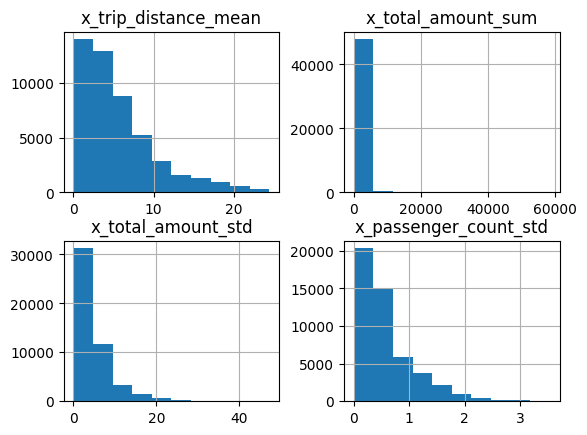

In [80]:
Xi[mc].hist()

In [81]:
Xi.value_counts('ex_',normalize=True)

ex_
0   0.865
1   0.135
Name: proportion, dtype: float64

In [82]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)

array([[<Axes: title={'center': 'x_trip_distance_mean'}>,
        <Axes: title={'center': 'x_total_amount_sum'}>],
       [<Axes: title={'center': 'x_total_amount_std'}>,
        <Axes: title={'center': 'x_passenger_count_std'}>]], dtype=object)

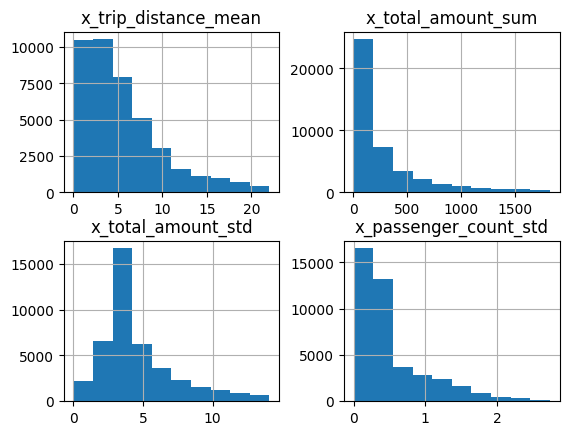

In [83]:
Xi[mc].hist()

## Escalamiento

In [84]:
scx = MinMaxScaler()
scy = MinMaxScaler()

In [87]:
Xt = Xi[um+mc].copy()
yt = train[um+vart].merge(Xt[um],on=um,how='inner')[um+vart]

In [90]:
scx.fit(Xt[mc])
scy.fit(yt[vart])

MinMaxScaler()

In [91]:
X,y = scx.transform(Xt[mc]),scy.transform(yt[vart])

## Aprendizaje supervisado

### Regresión Lineal

In [107]:
reg = LinearRegression()
hp = {'fit_intercept':[True,False]}
grid = GridSearchCV(reg,param_grid=hp,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)
grid.fit(X,y)
reg = grid.best_aestimator_
print(grid.best_params_,grid.best_score_)
mean_absolute_percentage_error(scy.inverse_transform(y),scy.inverse_transform(reg.predict(X)))

0.8681896329211177

### Redes Neuronales

In [112]:
ann = MLPRegressor()
hp = {'hidden_layer_sizes':[(a,b,) for a in range(2,9)   for b in range(2,9)],
'activation':['relu','tanh','logistic']
}
grid = GridSearchCV(ann,param_grid=hp,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)
grid.fit(X,y)
ann = grid.best_estimator_
print(grid.best_params_,grid.best_score_)
mean_absolute_percentage_error(scy.inverse_transform(y).reshape(-1, 1) ,scy.inverse_transform(ann.predict(X).reshape(-1, 1)))

0.6590678378684618

### Random Forest

In [113]:
rf = RandomForestRegressor()
hp = {'n_estimators':range(2,20), 'max_depth':range(2,7)}
grid = GridSearchCV(rf,param_grid=hp,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)
grid.fit(X,y)
rf = grid.best_estimator_
print(grid.best_params_,grid.best_score_)
mean_absolute_percentage_error(scy.inverse_transform(y).reshape(-1, 1) ,scy.inverse_transform(rf.predict(X).reshape(-1, 1)))

/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

{'max_depth': 6, 'n_estimators': 8} -17123811153365.62


0.6315714810318312

## **Generalización**

### Ajuste de pipeline completo

In [114]:
im.fit(train[mc])

SimpleImputer(strategy='median')

In [123]:
train['y^'] = scy.inverse_transform(rf.predict(scx.transform(im.transform(train[mc]))).reshape(-1,1))
valid['y^'] = scy.inverse_transform(rf.predict(scx.transform(im.transform(valid[mc]))).reshape(-1,1))
ot['y^'] = scy.inverse_transform(rf.predict(scx.transform(im.transform(ot[mc]))).reshape(-1,1))

/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/home/jose/entornos/tsc/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [125]:
{'train': mean_absolute_percentage_error(train['target'],train['y^']),
'valid': mean_absolute_percentage_error(valid['target'],valid['y^']),
'ot': mean_absolute_percentage_error(ot['target'],ot['y^'])}

{'train': 0.655060865953805,
 'valid': 0.6547521838258372,
 'ot': 0.7655547615632707}

<Axes: xlabel='target', ylabel='Density'>

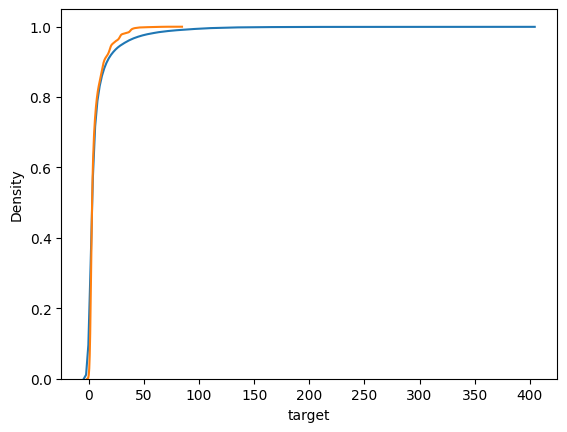

In [130]:
for v,li,ls in train[mc].describe(percentiles=[0.01,0.05,0.95,0.99]).T[['1%','99%']].reset_index().values:
    train = train[(train[v]>=li)&(train[v]<=ls)].reset_index(drop=True)

sns.kdeplot(train['target'],label='real',cumulative=True)
sns.kdeplot(train['y^'],label='pred',cumulative=True)

<Axes: xlabel='target', ylabel='Density'>

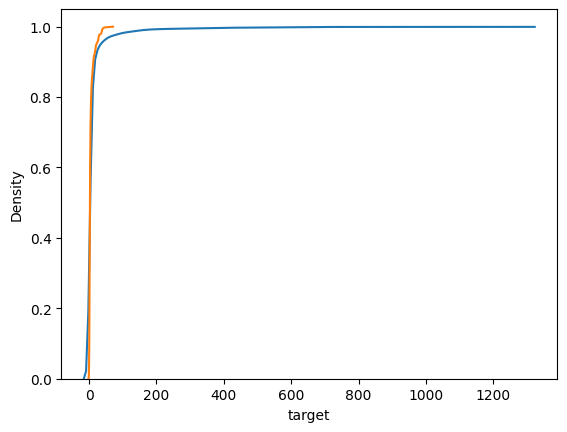

In [131]:

sns.kdeplot(valid['target'],label='real',cumulative=True)
sns.kdeplot(valid['y^'],label='pred',cumulative=True)

<Axes: xlabel='target', ylabel='Density'>

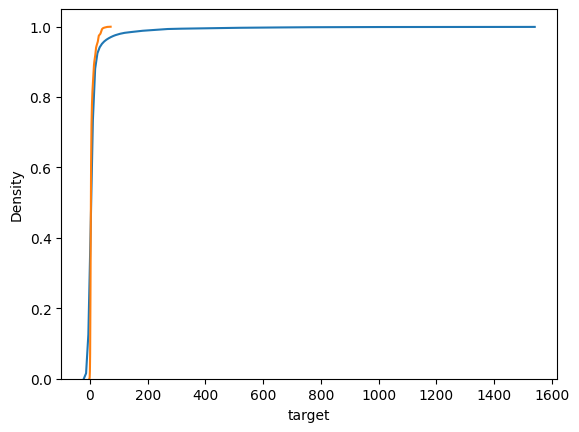

In [132]:

sns.kdeplot(ot['target'],label='real',cumulative=True)
sns.kdeplot(ot['y^'],label='pred',cumulative=True)

In [137]:
valid.sample(10)[um+vart+['y^']]

,PULocationID,DOLocationID,ancla,target,y^
16519,265,191,2020-11-01,1,1.551
12550,185,136,2021-03-01,1,2.494
1333,74,82,2021-07-01,2,2.557
11334,65,17,2021-07-01,96,28.460
817,60,93,2021-09-01,1,1.410
12460,134,235,2021-01-01,1,1.328
7742,121,90,2021-08-01,1,1.319
18185,169,168,2021-02-01,2,4.465
7868,47,75,2021-08-01,1,2.029
14237,95,9,2021-09-01,4,3.734


In [138]:
ot.sample(10)[um+vart+['y^']]

,PULocationID,DOLocationID,ancla,target,y^
8665,25,232,2021-12-01,2,2.657
9174,37,147,2021-12-01,1,1.319
8136,223,28,2021-12-01,2,1.902
5653,80,226,2021-11-01,5,5.987
9757,55,76,2021-12-01,3,4.711
8966,265,152,2021-12-01,1,1.496
10045,66,37,2021-12-01,3,3.628
13572,244,200,2022-01-01,8,13.945
4575,54,264,2021-11-01,1,1.319
13961,26,165,2022-01-01,1,1.319


## Para la IA

In [148]:
data['month'] = pd.to_datetime( pd.to_datetime(data['lpep_pickup_datetime']).dt.date.map(lambda x:x.strftime('%Y-%m-01'))).dt.date

In [151]:
aux = data.groupby(um[:-1]+['month']).agg(**{'total':('lpep_pickup_datetime','count')}).reset_index().dropna().reset_index(drop=True)
aux.columns = ['pickup_id_zone','dropoff_id_zone','month','rides']

In [154]:
aux.sample(10000).to_csv('green_taxi_trips_nyc.csv',index=False)

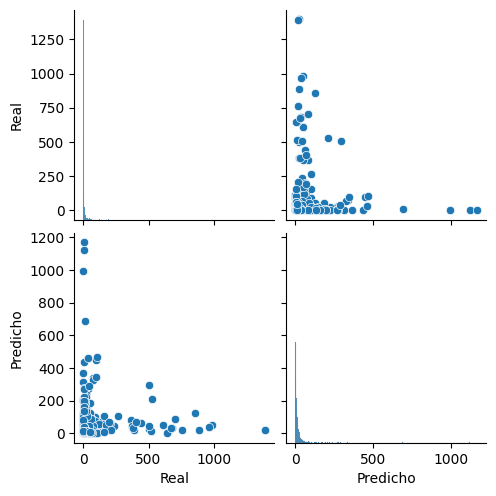

In [156]:
sns.pairplot(pd.read_csv('predictions_taxi_rides.csv'))